# Time series forcasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical prices of Bitcoin.

**Note:** This is not financial advice.

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-05-26 02:40:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.002s  

2022-05-26 02:40:24 (76.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates = ['Date'],
                 index_col = ['Date']) # parse the date column and tell pandas column 1 is a datetime
df.head()                 


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but ther's a 2787 samples.

Typically deep learing models like lots and lots and lots of samples (where lots and lots and lots can thousand to tens of thousand to millions).

A smaller number of samples is somthing you'll often run into with tine series data problems.

> **Note:** The **Seasonality** of time series dataset is referred as number of samples per year. So our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [5]:
# Only want closing price for each day
bitcoin_prices =pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


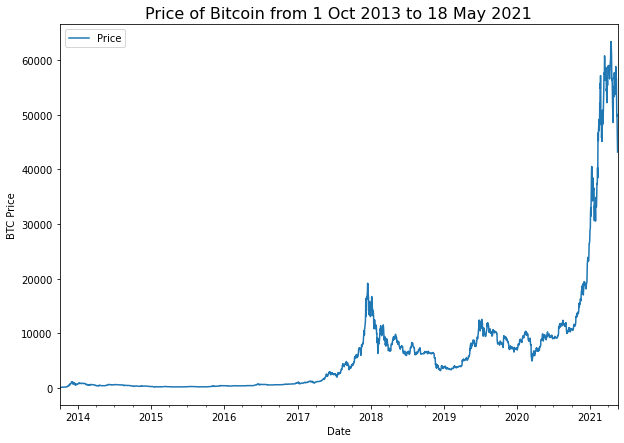

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend()

## Importing time series data with Python's CSV module


In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime


timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next (csv_reader) # skip first line (this get rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # gets the date as date (not the string)
    btc_price.append(float(line[2])) # get closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

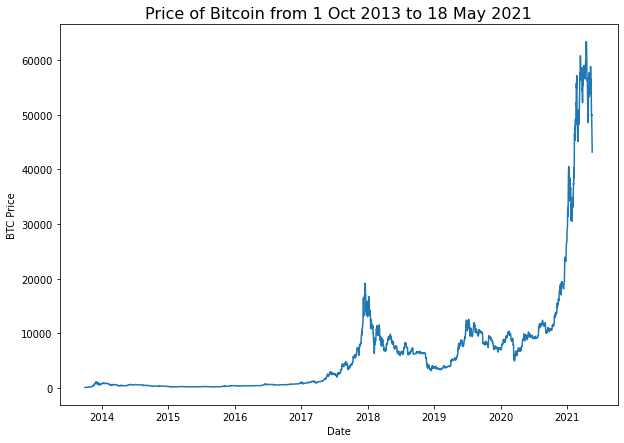

In [8]:
# Plot from csv
import matplotlib.pyplot as plt
# Import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [9]:
# Get Bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC Prices
                                                    test_size = 0.2,
                                                    random_state =42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

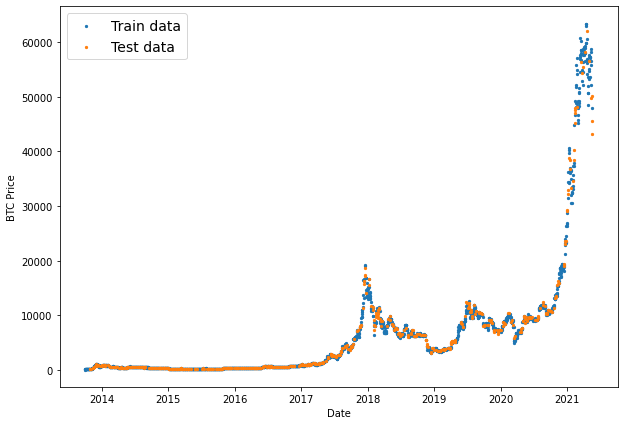

In [11]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train and test sets for time series (the right way)

In [12]:
# Create train and test splits the right way for time series data
split_size = int (0.8 * len (prices)) # 80% train and 20% test - you can change these value as needed, e.g. 90/10, 95/5

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_test), len(y_train)

(2229, 558, 558, 2229)

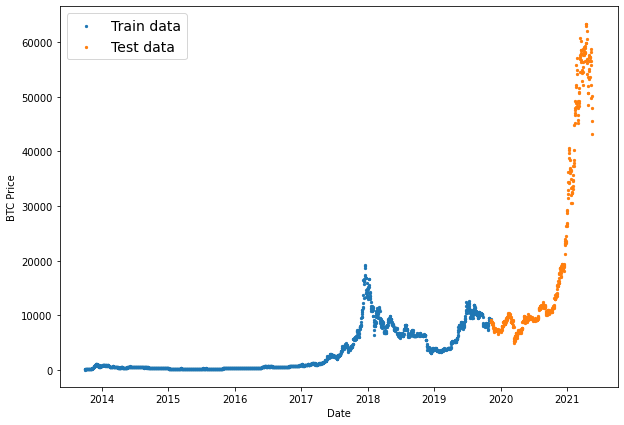

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [14]:
# Create function to plot time series data 
def plot_time_series(timesteps, values, format=".", start=0, end =None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default none
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)  


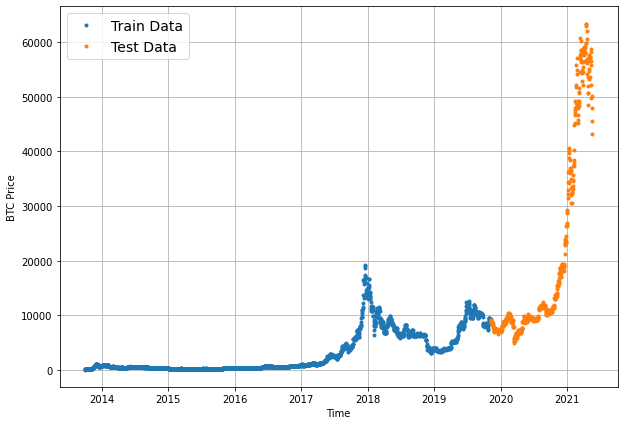

In [15]:
# Test out plotting functions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data") 

## Modelling Experiments 

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
*  **Horizon** = number of timesteps into the future we're going to predict
*  **Window size** = number of timesteps we're going to use to predict **horizon**

* Modelling Experiments we're running:
* 0	Naïve model (baseline)
* 1	Dense model, horizon=1, window=7	
* 2	Same as 1, horizon=1, window =30
* 3	Same as 1, horizon=7,	window=30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm	
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forcast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English: 

> The Prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep)- this is for horizon of 1.

In [16]:
# Create a naive forcast
naive_forcast = y_test [:-1]

naive_forcast[:10], naive_forcast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

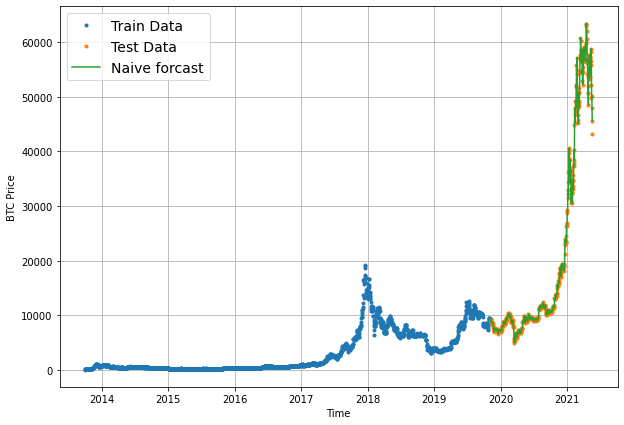

In [17]:
# Plot naive forcast 
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forcast, format="-", label="Naive forcast")

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with any kind of model is quite hard.

>  **Note:** For the sake of this notebook, an open system is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a closed system the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in open systems is generally quite poor.

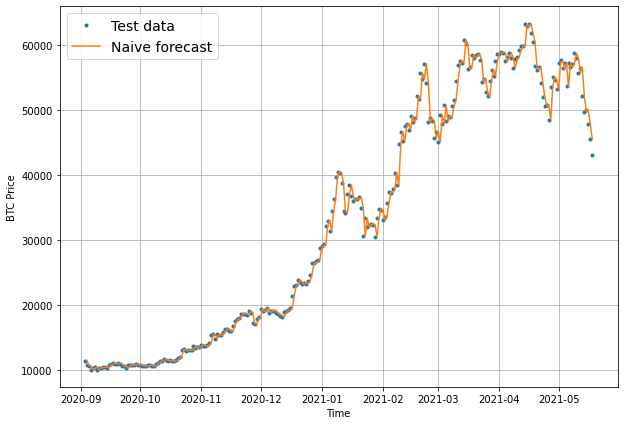

In [18]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forcast, format="-", start=offset, label="Naive forecast");

## Evaluating a time series model

Let's look into some time series evaluation metrics for time series forcasting.

What are we doing?

We're predicting a number, so that meanns we have a form of regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regressions metrics (which can also be used for time series forcasting):
* MAE - mean absolute error
* MSE - mean squred error
* RMSE - root mean squre error
* MAPE/sMape - (symmetric) mean absolute percentage error
* MASE - mean absolute scale error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: **how do our model's forcasts (y_pred) compare against the actual values (y_true or ground truth values)?**


> **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in Forecasting: Principles and Practice chapter 5.8, I'd recommend reading through here for a more in-depth overview of what we're going to practice.

In [19]:
import tensorflow as tf


In [20]:

# MASE implementation 
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae =tf.reduce_mean(tf.abs(y_true, y_pred))

  # Find MAE of naive forcast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)
  return mae / mae_naive_no_season


In [21]:
# Test MASE (this value should =1 or be very close to 1 with the naive forcast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forcast).numpy()

35.33123667641629

In [22]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various model evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

That's one good looking evaluation function!

Let's now see if it works....

In [23]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forcast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 35.331238,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [24]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

In [25]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other model you can use for baseline and actual forcasts

In this notebook we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forcasting models you may want to expriment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into supervised learning.

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup a global variable for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make tha prediction

In [28]:
# Create function to label windowed data 
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

   E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]




In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this is only works on small data.

We need a way to the above across our entire time series.

We could do this with Python for loops, however, for large time series, that would be quite low.

To speed things up, we'll leverage Numpy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will:
1.Creates a window step of specific window size, for example: [[0, 1, 2, 3, 4, 5, 6, 7]]
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

>  **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np

# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns 1D array into 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling latter)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(f"Window indexes:\n {window_indexes, window_indexex.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows , labels

In [31]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label [125.96116]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** There's function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function : https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning window into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
 # Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against the other model's best performance.

For example if our model perform the best on epoch 55 (but we're training it for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [38]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense Model (window = 7, horizon = 1) 

Our first deep model is going to be simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizers and mae loss function
* Batch size of 128
* 100 epochs

Why these values?
 
I picked them out of the experimentation.

* **Hyperparameters:** values a machine learning practioner (you!) can adjust themselves
* **Parameters:** values a model learns on its own

In [39]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reporducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
     layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense")

# 2. Compile a model
model_1.compile(loss="mae",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["mae"]) # We don't actually need this when we've loss function is mae

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name =model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 40ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9993 - val_mae: 1005.9993
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2237 - val_mae: 895.2237
Epoch 6/100
18/18 [==============================] - 0s 27ms/step - loss: 158.5210 - mae: 158.5210 - val_loss: 855.1984 - val_mae: 855.1984
Epoch 7/100
18/18 [==============================] - 0s 24ms/step - loss: 151.3566 - mae: 151.3566 - val_loss: 840.9166 - val_mae: 840.9166
Epoch 8/100
18/1

In [40]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758


[585.9757690429688, 585.9757690429688]

In [41]:
# Load in saved best performing model_1 and evaluate it on test data 
model_1 =tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510


[568.9510498046875, 568.9510498046875]

## Making forcasts with a model (on the test dataset)

To make "forcasts" on the test dataset (note: these won't be actual forcasts, they're only psuedo forcasts because actual forcasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict` method
4. Returns the predictions



In [42]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  forcast = model.predict(input_data)
  return tf.squeeze(forcast) # return 1D arary of prediction

In [43]:
# Make prediction using model_1 on test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [44]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 35.303753,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [45]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 35.331238,
 'mse': 1147547.0,
 'rmse': 1071.2362}

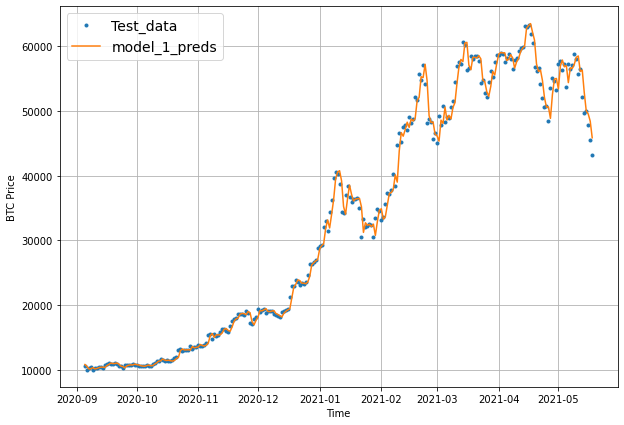

In [46]:
# Let's plot our model 1 prediction
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [47]:
HORIZON =1 # predict 1 step at a time (one day of bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [48]:
# Make window data with apropriate window and horizon size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows),len(full_labels)

(2757, 2757)

In [49]:
# Make train and test windows 
train_windows, test_windows, train_labels, test_labels =make_train_test_splits(windows=full_windows,
                                                                               labels=full_labels,
                                                                               test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [50]:
train_labels[:3], train_windows[:3]

(array([[196.02499],
        [198.04883],
        [198.93233]]),
 array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 13

In [51]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
     layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON)                          
], name="model_2_dense")

# Compile 
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [52]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332


659.3331909179688

In [53]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741


605.8740844726562

In [54]:
# Get forcast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [55]:
# Evaluate results for model 2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mape': 2.726445,
 'mase': 35.271255,
 'mse': 1273360.8,
 'rmse': 1128.4329}

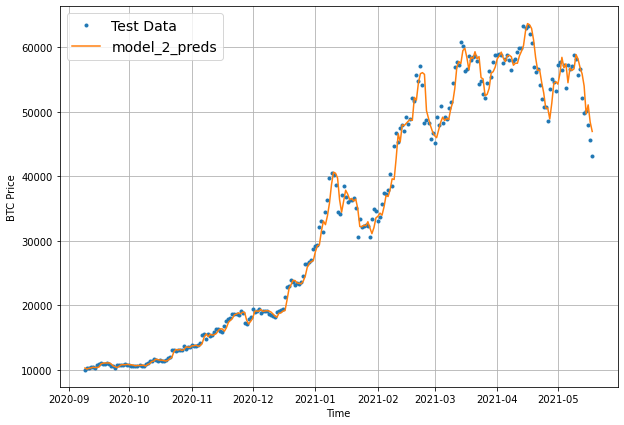

In [56]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense (window = 30, horizon = 7)

In [57]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [58]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [59]:
tf.random.set_seed(42)

# create model (same as model_1 excpet with different data input and output sizes)

model_3 =tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON)
], name="model_3_dense")


# compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())


# Fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [60]:
# Evaluate the model on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525


1300.1524658203125

In [61]:
# Load best version of model 3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063


1237.50634765625

In [62]:
# Make prediction with model 3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [63]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

In [64]:
# Evaluate model 3 results
model_3_results = evaluate_preds(y_true =tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53293 ,
         537.854   ,  545.6617  ,  485.9228  ,  584.49713 ,  687.38214 ,
         836.2264  ,  755.1576  ,  731.4957  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80217 ,  188.10805 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.8148  ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78871 ,  190.81174 ,  179.15994 ,  228.26004 ,
         314.44022 ,  379.09235 ,  278.32526 ,  295.34702 ,  299.3852  ,
         248.64983 ,  299.75668 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.9412  ,
          54.825542,   73.79555 ,  103.60121 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57199 ,  146.91273 ,  240.42912 ,
         351.00656 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.9811  ,  277.2947  ,  301.8247  ,  455.718   ,
         458.9603  ,  503.4438  ,  522.3119 

## Make our evalution function work for larger horizons


In [65]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [66]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results


{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 35.575474,
 'mse': 5405198.5,
 'rmse': 1425.7477}

Time to visualize.

If our prediction evaluation metrics were mutli-dimensional, how do you think the predictions will look like if we plot them?

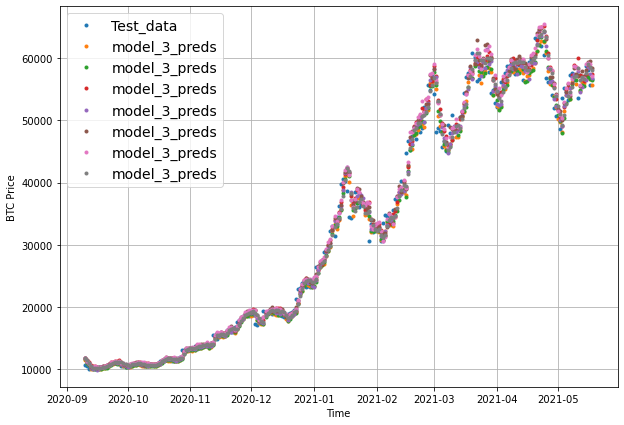

In [67]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")


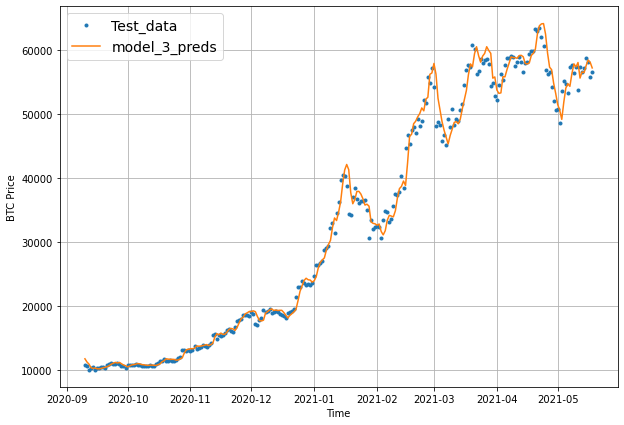

In [68]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our model is performing the best so for?

So we've trained a few models, now let's compare them and see how they've gone...

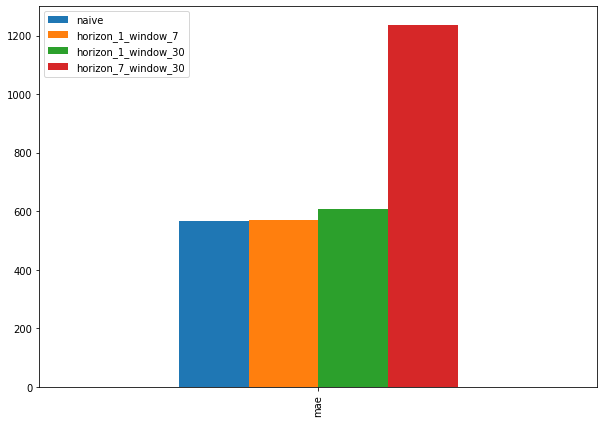

In [69]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

>  **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> **Resource:** For more on how autocorelation influences a model's predictions, see the article: https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D

In [88]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [89]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [90]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

TO use the Conv1D layer, we need an input shape of:` (batch_size, timesteps, input_dim)`

However, our data isn't in that shape yet...

In [91]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [92]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [93]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [94]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_11 (Lambda)          (None, 1, 7)              0         
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_12 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 610.1541


610.154052734375

In [96]:
# Load back in best performing conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.8284


570.828369140625

In [98]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.627, 8708.294,
       8661.667, 8494.839, 8435.316, 8492.114], dtype=float32)>

In [99]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.82837,
 'mape': 2.5593357,
 'mase': 35.303753,
 'mse': 1176671.2,
 'rmse': 1084.7448}

## Model 5: RNN (LSTM)

Let's build a RNN model for our time series data.

We'll use the same data we created previously.

In [104]:
tf.random.set_seed(42)

# Let's build an LSTM model with the functional API
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs, outputs=output, name="model_5_LSTM")


# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2581.3218 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 109ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 947.0196 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
10/18 [===============>..............] - ETA: 0s - loss: 273.4720INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 196.5330INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 170.0374INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 181.8447INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 155.8568INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 157.6371 - val_loss: 887.1069
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 159.0397 - val_loss: 941.6474
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 166.8723 - val_loss: 932.8405
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 166.4009 - val_loss: 912.6633
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 169.3308 - val_loss: 911.7051
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 163.4948 - val_loss: 912.0140
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 161.2514 - val_loss: 954.6791
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 160.0829 - val_loss: 929.0612
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 149.2168INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 150.1265 - val_loss: 837.1278
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 146.4163 - val_loss: 853.6611
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 160.1423 - val_loss: 872.8708
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 162.7851 - val_loss: 948.1257
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 157.5906 - val_loss: 879.2180
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 152.0355 - val_loss: 862.6780
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 150.7321 - val_loss: 837.5231
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 149.8567 - val_loss: 863.5777
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 147.5116 - val_loss: 857.3817
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 14

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 145.0650 - val_loss: 814.3984
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 152.5446INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 143.5609 - val_loss: 803.5718
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 144.5681INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 131ms/step - loss: 141.8002 - val_loss: 787.3266
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 140.9612 - val_loss: 802.5436
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 141.4158 - val_loss: 792.5001
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 138.4217INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 138.1068 - val_loss: 769.0403
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 138.4725INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 136.2222 - val_loss: 766.1755
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 136.6590 - val_loss: 799.5143
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 142.0704INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 136.5250 - val_loss: 751.2918
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 133.8809 - val_loss: 760.8373
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 154.6745 - val_loss: 755.5355
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9530 - val_loss: 830.3299
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 142.5454INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 133.3048 - val_loss: 721.6965
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 133.0458INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 130.8634 - val_loss: 716.1732
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 131.4340 - val_loss: 722.9932
Epoch 41/100
11/18 [=================>............] - ETA: 0s - loss: 134.2949INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 96ms/step - loss: 127.9265 - val_loss: 706.7326
Epoch 42/100
18/18 [==============================] - 0s 9ms/step - loss: 126.9680 - val_loss: 711.0535
Epoch 43/100
12/18 [===================>..........] - ETA: 0s - loss: 122.4124INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 125.9146 - val_loss: 699.5353
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 120.2402INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 126.0430 - val_loss: 694.9197
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 123.5075INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 98ms/step - loss: 124.3085 - val_loss: 688.0770
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 125.3113 - val_loss: 688.4482
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8175 - val_loss: 697.9518
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 120.0374INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 174ms/step - loss: 123.1645 - val_loss: 678.4640
Epoch 49/100
18/18 [==============================] - 0s 11ms/step - loss: 122.5108 - val_loss: 691.3553
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 124.5405 - val_loss: 711.7105
Epoch 51/100
18/18 [==============================] - 0s 11ms/step - loss: 125.1063 - val_loss: 767.2324
Epoch 52/100
18/18 [==============================] - ETA: 0s - loss: 124.1389INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 182ms/step - loss: 124.1389 - val_loss: 667.4606
Epoch 53/100
16/18 [=========================>....] - ETA: 0s - loss: 121.1608INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 158ms/step - loss: 120.9903 - val_loss: 664.1364
Epoch 54/100
18/18 [==============================] - 0s 12ms/step - loss: 120.4420 - val_loss: 668.9785
Epoch 55/100
13/18 [====================>.........] - ETA: 0s - loss: 127.4062INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 183ms/step - loss: 120.3250 - val_loss: 657.9633
Epoch 56/100
16/18 [=========================>....] - ETA: 0s - loss: 121.4405INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 146ms/step - loss: 120.8701 - val_loss: 651.8960
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 123.8955 - val_loss: 676.6168
Epoch 58/100
14/18 [======================>.......] - ETA: 0s - loss: 118.7292INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 145ms/step - loss: 119.2845 - val_loss: 647.5352
Epoch 59/100
18/18 [==============================] - 0s 12ms/step - loss: 118.8512 - val_loss: 650.0970
Epoch 60/100
18/18 [==============================] - 0s 10ms/step - loss: 119.7555 - val_loss: 647.5707
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 120.2817 - val_loss: 713.6547
Epoch 62/100
18/18 [==============================] - 0s 14ms/step - loss: 125.3769 - val_loss: 794.2551
Epoch 63/100
18/18 [==============================] - 0s 9ms/step - loss: 124.9135 - val_loss: 664.7371
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2151 - val_loss: 674.3691
Epoch 65/100
14/18 [======================>.......] - ETA: 0s - loss: 120.9495INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 146ms/step - loss: 120.2009 - val_loss: 642.3017
Epoch 66/100
14/18 [======================>.......] - ETA: 0s - loss: 118.4527INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 153ms/step - loss: 118.4315 - val_loss: 641.6986
Epoch 67/100
16/18 [=========================>....] - ETA: 0s - loss: 116.3059INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 178ms/step - loss: 119.0471 - val_loss: 634.3810
Epoch 68/100
18/18 [==============================] - 0s 13ms/step - loss: 116.6638 - val_loss: 636.2444
Epoch 69/100
18/18 [==============================] - 0s 14ms/step - loss: 120.7408 - val_loss: 634.6294
Epoch 70/100
17/18 [===========================>..] - ETA: 0s - loss: 114.0817INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 227ms/step - loss: 115.4599 - val_loss: 626.6803
Epoch 71/100
18/18 [==============================] - 0s 13ms/step - loss: 115.9339 - val_loss: 656.0881
Epoch 72/100
18/18 [==============================] - 0s 10ms/step - loss: 119.8699 - val_loss: 632.4766
Epoch 73/100
18/18 [==============================] - 0s 15ms/step - loss: 116.7878 - val_loss: 632.6957
Epoch 74/100
18/18 [==============================] - 0s 11ms/step - loss: 115.9789 - val_loss: 628.7859
Epoch 75/100
18/18 [==============================] - 0s 19ms/step - loss: 116.2214 - val_loss: 648.9557
Epoch 76/100
16/18 [=========================>....] - ETA: 0s - loss: 116.7651INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 192ms/step - loss: 115.7740 - val_loss: 619.5612
Epoch 77/100
18/18 [==============================] - 0s 10ms/step - loss: 116.0982 - val_loss: 676.6537
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 117.8428 - val_loss: 638.4432
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 114.9824INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 114.5818 - val_loss: 615.1121
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 113.7328 - val_loss: 627.4662
Epoch 81/100
18/18 [==============================] - 0s 14ms/step - loss: 113.7289 - val_loss: 633.0526
Epoch 82/100
18/18 [==============================] - 0s 13ms/step - loss: 116.9833 - val_loss: 627.6213
Epoch 83/100
18/18 [==============================] - 0s 14ms/step - loss: 113.7818 - val_loss: 646.7040
Epoch 84/100
18/18 [==============================] - 0s 14ms/step - loss: 116.0995 - val_loss: 634.6423
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 115.7939 - val_loss: 626.9783
Epoch 86/100
18/18 [==============================] - 0s 15ms/step - loss: 116.1706 - val_loss: 615.6919
Epoch 87/100
17/18 [===========================>..] - ETA: 0s - loss: 113.3898INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 5s 270ms/step - loss: 112.9052 - val_loss: 610.0921
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 115.7052INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 159ms/step - loss: 112.7499 - val_loss: 607.0144
Epoch 89/100
18/18 [==============================] - 0s 13ms/step - loss: 112.3718 - val_loss: 634.9384
Epoch 90/100
18/18 [==============================] - 0s 11ms/step - loss: 117.4136 - val_loss: 640.5466
Epoch 91/100
18/18 [==============================] - 0s 14ms/step - loss: 115.2679 - val_loss: 623.8540
Epoch 92/100
18/18 [==============================] - 0s 15ms/step - loss: 113.5989 - val_loss: 612.2767
Epoch 93/100
13/18 [====================>.........] - ETA: 0s - loss: 115.0784INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 173ms/step - loss: 113.3057 - val_loss: 602.9005
Epoch 94/100
18/18 [==============================] - 0s 14ms/step - loss: 111.8213 - val_loss: 606.6011
Epoch 95/100
16/18 [=========================>....] - ETA: 0s - loss: 110.1155INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 120ms/step - loss: 111.7478 - val_loss: 600.6985
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 113.2104 - val_loss: 606.9620
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9565 - val_loss: 614.7238
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5009 - val_loss: 601.0434
Epoch 99/100
12/18 [===================>..........] - ETA: 0s - loss: 110.1989INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 97ms/step - loss: 111.3801 - val_loss: 598.6812
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7539 - val_loss: 601.1650


In [105]:
# Load in best model 5 and evaluate on tha test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 598.6813


598.6813354492188

In [107]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5,test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8990.325, 8818.501, 8999.41 , 8839.997, 8732.248], dtype=float32)>

In [108]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 598.6813,
 'mape': 2.6928957,
 'mase': 35.303753,
 'mse': 1280250.8,
 'rmse': 1131.4816}

>  **Note:**Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add whether or not a Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 2
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [109]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [110]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [111]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [112]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


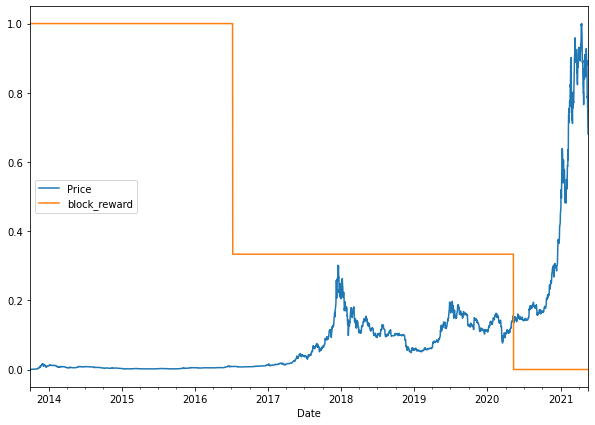

In [113]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed datasets with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper function above.

However, since we've got a multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [114]:
# Setup dataset hyperparameters
HORIZON =1
WINDOW_SIZE=7 

In [117]:
# Make a copy of Bitcoin historical data with block_reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns 
for i in range(WINDOW_SIZE): #shift value for each size in WINDOW_SIZE
   bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)  

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [118]:
# Create x (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [119]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [120]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)


In [123]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


In [125]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 626.7449


626.744873046875

In [126]:
# Load in and evaluate best performing model
model_6=tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 567.8910


567.8909912109375

In [128]:
# Make prediction with multivariate model
model_6_preds = model_6.predict(X_test)
model_6_preds[:10]

array([[8844.684],
       [8769.905],
       [9045.17 ],
       [8747.686],
       [8728.429],
       [8772.757],
       [8667.292],
       [8503.437],
       [8470.313],
       [8527.244]], dtype=float32)

In [129]:
# Evaluate prediction to get evel metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 17148.238,
 'mape': 113.36508,
 'mase': 35.303753,
 'mse': 615102600.0,
 'rmse': 23719.365}

## Model 7: N-BEATS algorithm

Let's now try to build the biggest baddest (though maybe not the baddest, as in, it really perform well...) time series forcasting model we've built so for.

More specifically, we're going to replicating the algorithm in Figure 1 from the following paper: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our own problem

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing:

https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [133]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
   def __init__(self,
                input_size: int,
                theta_size: int,
                horizon: int,
                n_neurons: int,
                n_layers: int,
                **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contain stacks of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

   def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast         

Let's tes our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [134]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4) 

In [135]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [136]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ]
Forecast: -0.7554212808609009


### Preparing data for N-BEATS algorith using `tf.Data`

To make our input load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: 
https://www.tensorflow.org/guide/data_performance

In [137]:
HORIZON = 1
WINDOW_SIZE = 7

In [138]:
# Create N-BEATS data inputs (N-BEATS work with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [139]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"]= bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [141]:
# Make feature and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train =X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_train)

(2224, 556, 2224, 2224)

In [142]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up a hyperparameters for N-BEATS algorithm 

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://arxiv.org/abs/1512.03385

In [143]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections(subtract and add).

In [144]:
# Make tensors
tensor_1 =tf.range(10) + 10
tensor_2 =tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors : {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted : {subtracted.numpy()}")
print(f"Added : {added.numpy()}")


Input tensors : [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted : [10 10 10 10 10 10 10 10 10 10]
Added : [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forcasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forcasts
6. Create the double residual stacking using subtract and add layers 
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with the MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with other models) and Adam optimizer with the default setting as per section 5.2 of N-BEATS paper 
9. Fit the N-Beats model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
     * tf.keras.callbacks.EarlyStopping() - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
     * tf.keras.callbacks.ReduceLROnPlateau() - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make) 

In [145]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 241: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 341: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 16s, sys: 2.1 s, total: 1min 18s
Wall time: 1min 41s


In [147]:
# Evaluate N-Beats model on the test dataset 
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 53ms/step - loss: 583.4446 - mae: 583.4446 - mse: 1198012.5000


[583.4446411132812, 583.4446411132812, 1198012.5]

In [148]:
# Make prediction with N-Beats model 
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8932.642, 8849.316, 8983.45 , 8768.327, 8786.147, 8768.131,
       8661.106, 8563.443, 8495.237, 8518.734], dtype=float32)>

In [150]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 583.44464,
 'mape': 2.7202241,
 'mase': 35.303753,
 'mse': 1198012.5,
 'rmse': 1094.5376}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as model_1 or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

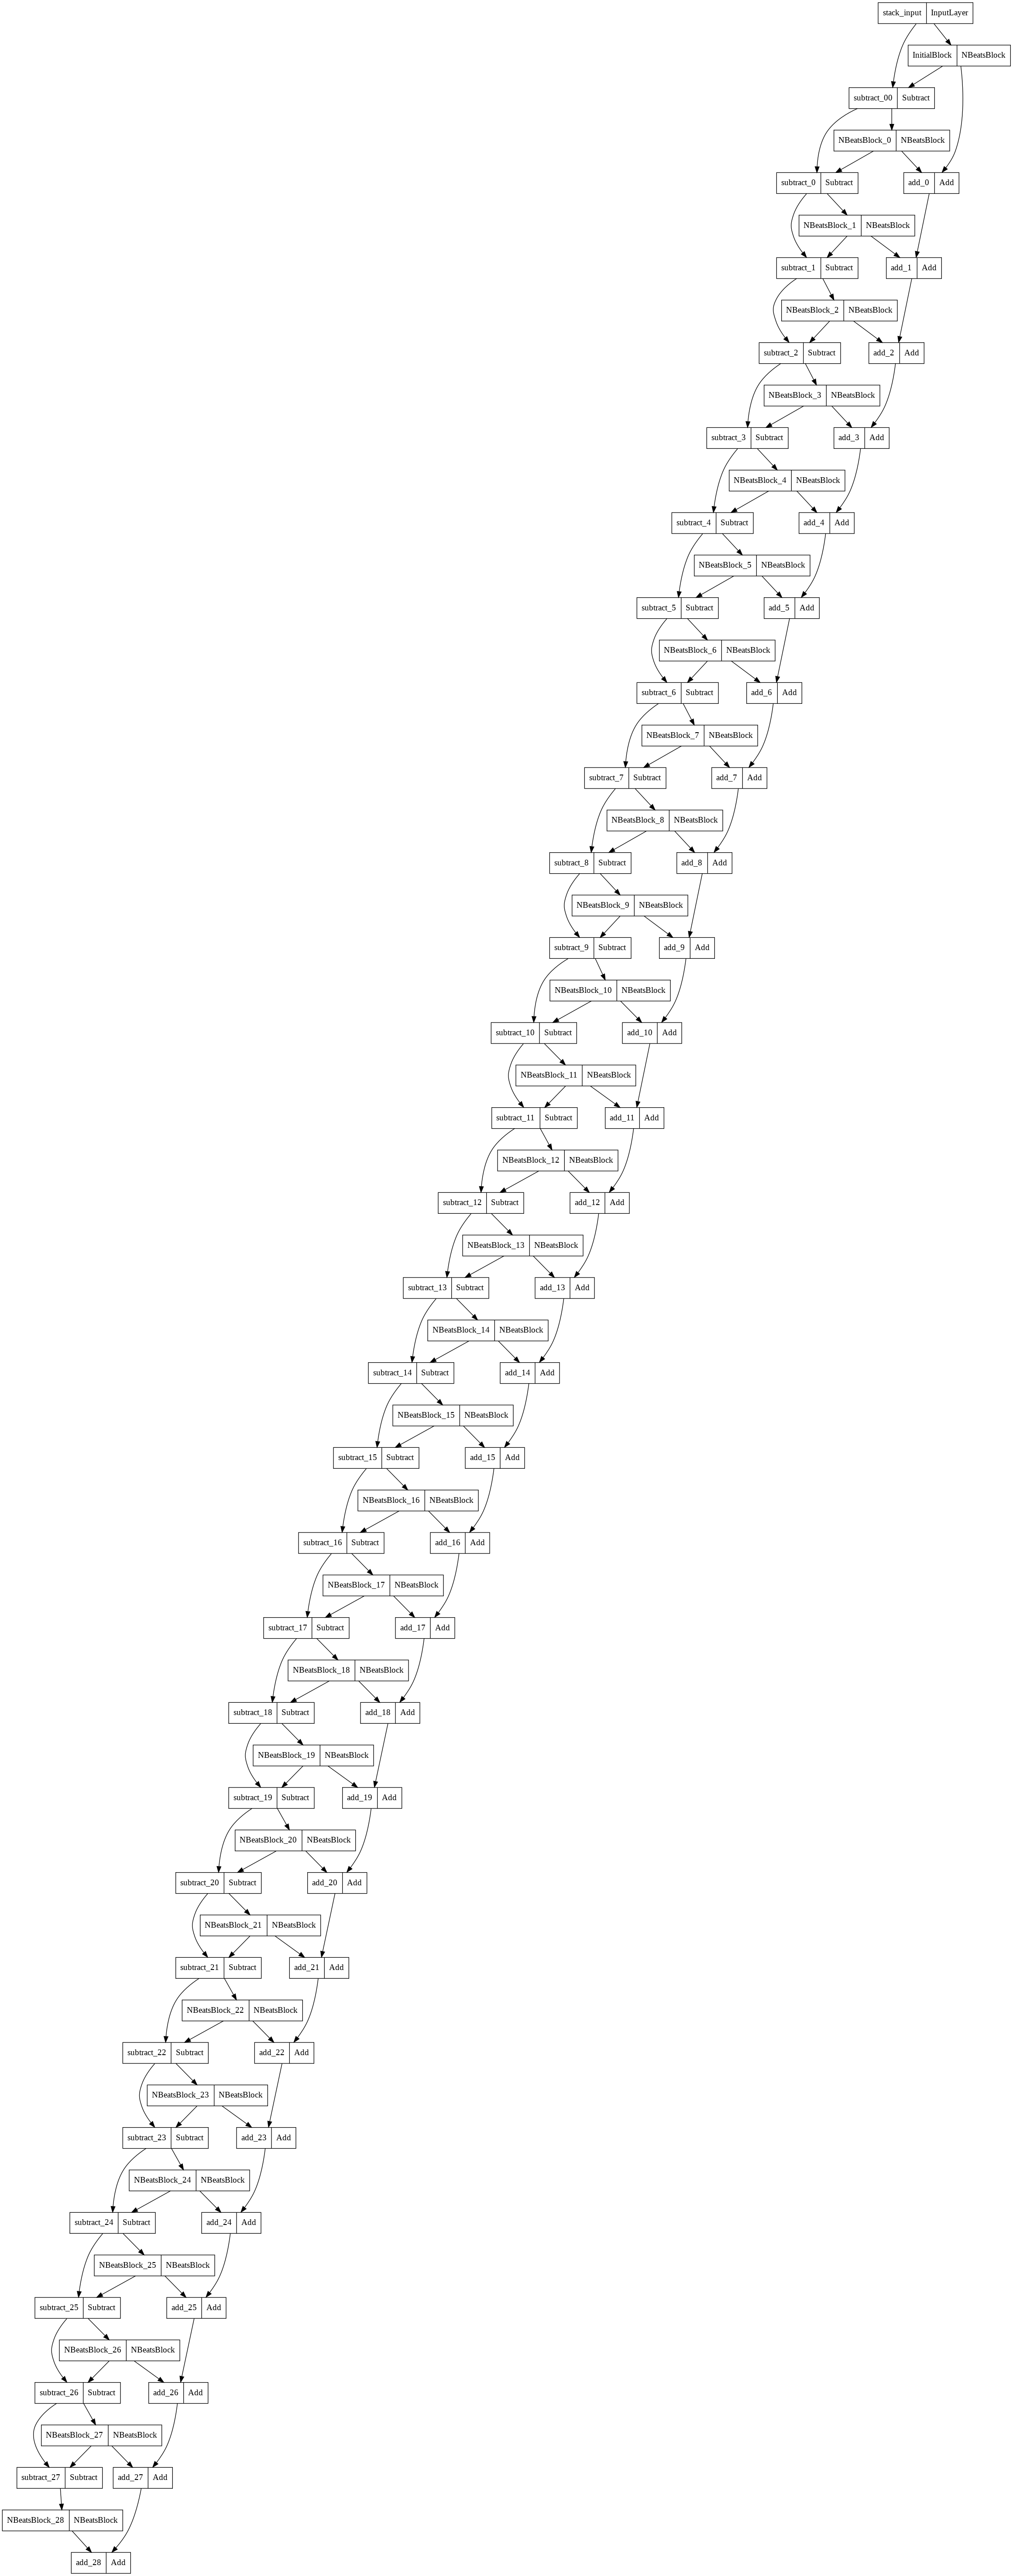

In [151]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many different models to predict a common goal.

### Constructing and fitting and ensemble of models (using different loss functions)

In [152]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [153]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 846: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 975: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 499: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 163: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 276: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 376: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

### Make predictions with our ensemble model

In [154]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [155]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8803.924 ,  8773.453 ,  9029.7295, ..., 50196.992 , 49204.68  ,
        46611.27  ],
       [ 8738.04  ,  8723.04  ,  9039.506 , ..., 49308.594 , 48636.434 ,
        45488.27  ],
       [ 8737.147 ,  8720.211 ,  9092.412 , ..., 49850.207 , 47903.344 ,
        45273.805 ],
       ...,
       [ 8894.633 ,  8737.2   ,  9011.03  , ..., 49251.36  , 49661.68  ,
        46409.805 ],
       [ 8729.483 ,  8804.218 ,  9104.747 , ..., 49597.9   , 48546.3   ,
        45038.277 ],
       [ 8817.422 ,  8761.004 ,  9039.576 , ..., 49727.45  , 48074.76  ,
        45830.23  ]], dtype=float32)>

Our ensemble preds comeout in multiple dimensions to combine into **point predictions** we can leverage the mean of all the prediction or the median :https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/#:~:text=Combining%20Regression%20Predictions-,Combining%20Predictions%20for%20Ensemble%20Learning,achieved%2C%20namely%20better%20predictive%20performance.

In [156]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 566.32544,
 'mape': 2.5814157,
 'mase': 35.303753,
 'mse': 1140284.1,
 'rmse': 1067.8408}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So for we've been making point prediction with our models.

E.g. horizon=1, our model predicts tomorrow's price of Bitcoin will be $50,000USD 

Wouldn't it helpful if knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48000 t0 52000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootsrap method:
1. Take prediction from number of randomly initliazed model's(we've got this thanks to our ensemble model)
2. Meaure the standard deviation of the prediction
3. Multiply the standard deviation by 1.96 (assumong the distribution in Gaussian/Normal, 95% of observation fall within 1.96 standard deviation of the mean)
4. To get the prediction intervals upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the prediction made in (1)

* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [157]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

> **Resource:** Many of steps we've taken above have inspired/refrenced from the Machine Learning Mastry blog post on https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/

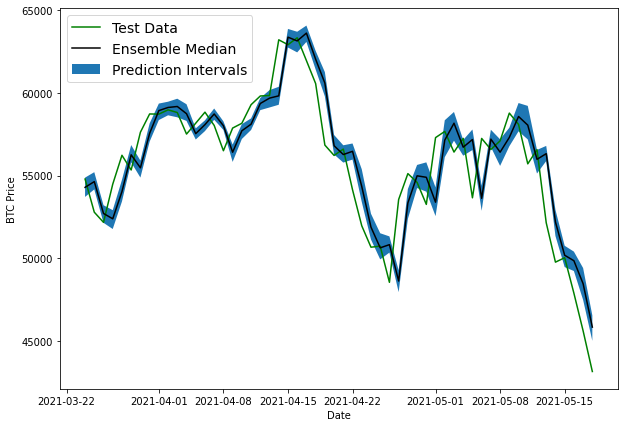

In [158]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So for all of our model's predictions lagging behind the test data...

As is they are replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These predictions intervals are estimates themselves. And they have been created with the assumption that's our model data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitativaly and quantitativaly answer the questions:
1. What can my model know? (with perfect data, what's possible for model to learn)
2. What doesn't my model know? (what can a model never predict? or would it will be helpful if a model could tell you that when it's making prediction, it's doesn't actually know it it's right or not?

There are two types of uncertainty in machine learning you should know about:
*  **Aleatoric Uncertainty** - this type of uncertainty can not be reduced and it is often referred as "data" uncertainty or subway uncertainty 
*  **Epistemic Uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty 

* **MIT:** https://youtu.be/toTcf7tZK8c

## Model 9: Train a model on the full historical data to make predictions into the future

So for all of our models have predicted on the test dataset, however, this is only pseudofuture.

Let's now build a model which is capable of predicting into the future.

In [159]:
bitcoin_prices_windowed.head()  

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [160]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [161]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [163]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name ="model_9_future_model")

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions into future

In [164]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

To make predictions into the future we want a function which:

1. Takes as input:
* a list of values (Bitcoin historical data)
* a trained model (such as `model_9`)
* a window into the future to predict (our `INTO_FUTURE` variable)
* the window size a model was trained (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates a empty list for future forcasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequence which update to remove the first value and append the latest prediction.


In [168]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

>  **Exercise:** In terms of a forecasting model, what might another approach to our make_future_forecasts() function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.

> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.

> As it is, the make_future_forecasts() function skips the retraining of a model part.

In [169]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9375

Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9375    ] -> Prediction: 48522.96484375

Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9375     48522.96484375] -> Prediction: 48137.203125

Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9375     48522.96484375 48137.203125  ] -> Prediction: 47880.6328125

Predicting on: 
 [45604.61575361 43144.47129086 55764.46484375 50985.9375
 48522.96484375 48137.203125   47880.6328125 ] -> Prediction: 46879.7109375

Predicting on: 
 [43144.47129086 55764.46484375 50985.9375     48522.9648437

### Plot future forcast

In [170]:
future_forecast[:10]

[55764.465,
 50985.938,
 48522.965,
 48137.203,
 47880.633,
 46879.71,
 48227.594,
 53963.684,
 49685.547,
 47596.168]

In [171]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [172]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [173]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [174]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.465, 50985.938, 48522.965, 48137.203, 47880.633,
        46879.71 , 48227.594, 53963.684, 49685.547, 47596.168, 48114.426,
        48807.996, 48623.844, 50178.71 ], dtype=float32))

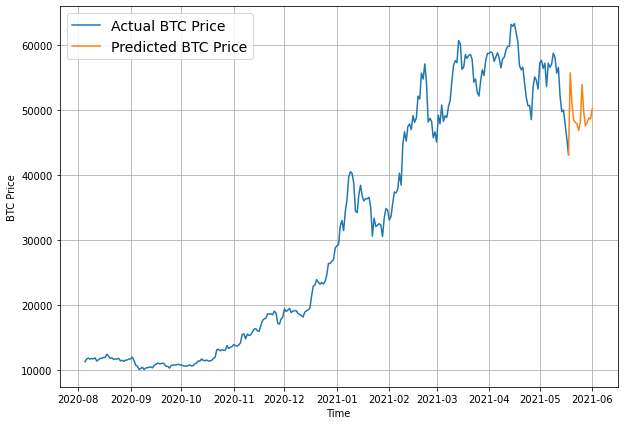

In [175]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forcast is BS (the turkey problem)

In [176]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [177]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]


[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [178]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

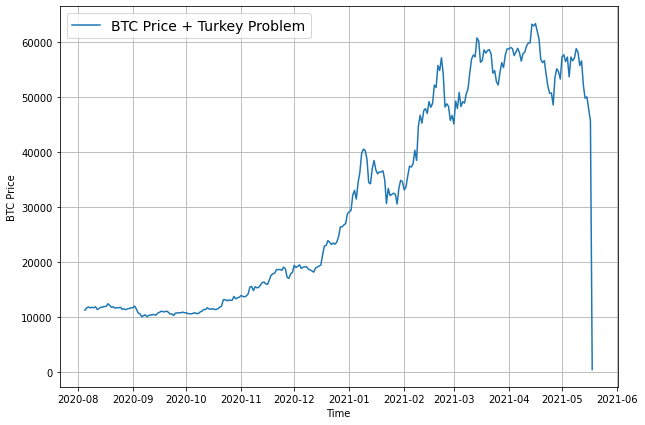

In [179]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [180]:

# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Build a turkey model (model to predict on turkey data)

In [181]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: model_experiments/Turkey_Model/assets


In [182]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 786.2137


786.2136840820312

In [183]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 638.3048


638.3048095703125

In [184]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8858.391, 8803.98 , 9039.576, 8785.936, 8778.044, 8735.638,
       8684.117, 8558.66 , 8461.373, 8542.205], dtype=float32)>

In [185]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17144.766,
 'mape': 121.58286,
 'mase': 30.980312,
 'mse': 615487740.0,
 'rmse': 23743.305}

In [186]:
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 35.303753,
 'mse': 1171743.8,
 'rmse': 1082.4711}

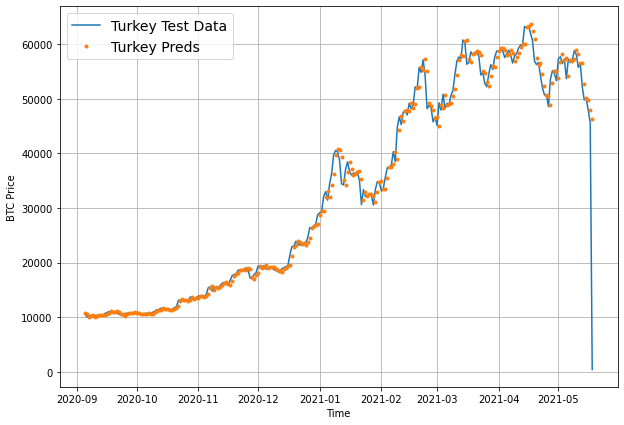

In [187]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

## Compare models

In [188]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,35.331238
model_1_dense_w7_h1,568.951050,1.171744e+06,1082.471069,2.544898,35.303753
model_2_dense_w30_h1,605.874084,1.273361e+06,1128.432861,2.726445,35.271255
model_3_dense_w30_h7,1237.506348,5.405198e+06,1425.747681,5.558878,35.575474
model_4_CONV1D,570.828369,1.176671e+06,1084.744751,2.559336,35.303753
model_5_LSTM,598.681274,1.280251e+06,1131.481567,2.692896,35.303753
model_6_multivariate,17148.238281,6.151026e+08,23719.365234,113.365082,35.303753
model_8_NBEATs,583.444641,1.198012e+06,1094.537598,2.720224,35.303753
model_9_ensemble,566.325439,1.140284e+06,1067.840820,2.581416,35.303753
model_10_turkey,17144.765625,6.154877e+08,23743.304688,121.582863,30.980312


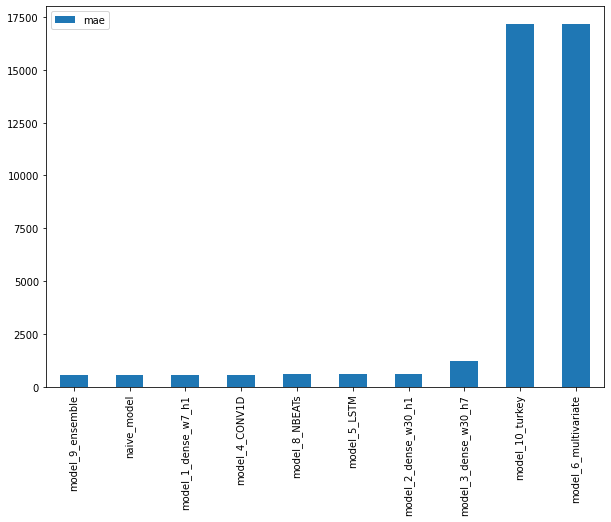

In [190]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");